# Iterative Closest Point Localization

## Overview 

The Iterative Closest Point (ICP) algorithm is a localization algorithm primarily used in the fields of computer vision and robotics to align or register two point clouds. This is crucial in a variety of applications such as 3D reconstruction, object recognition, and autonomous navigation, where precise alignment of different scans of an environment is necessary.

The ICP algorithm is designed to minimize the difference between two clouds of points (source and target) by finding the best rigid transformation (rotation and translation) that aligns the source point cloud to the target point cloud. The algorithm assumes that the two point clouds are approximately aligned and iteratively refines the transformation to enhance the alignment.

## Mathematical Foundations of ICP

Following the overview where the Iterative Closest Point (ICP) algorithm was introduced for aligning two point clouds, we delve into the mathematical formulations that constitute this algorithm.

### Problem

 Given two sets of points:

1. $P = {p_1, \cdots, p_N}$ - Source Points
2. $Q = {q_1, \cdots, q_N}$ - Target Points

With centroids:

1. $\mu_P = \frac{1}{N} \sum_{i=1}^N p_i$ - Centroid of the source points 
2. $\mu_Q = \frac{1}{N} \sum_{i=1}^N q_i$ - Centroid of the target points

The objective of the ICP algorithm is to discover the rigid transformation, consisting of a rotation matrix $R$ and a translation vector $t$, that minimizes the error when applied to the source points $P$

**Example**

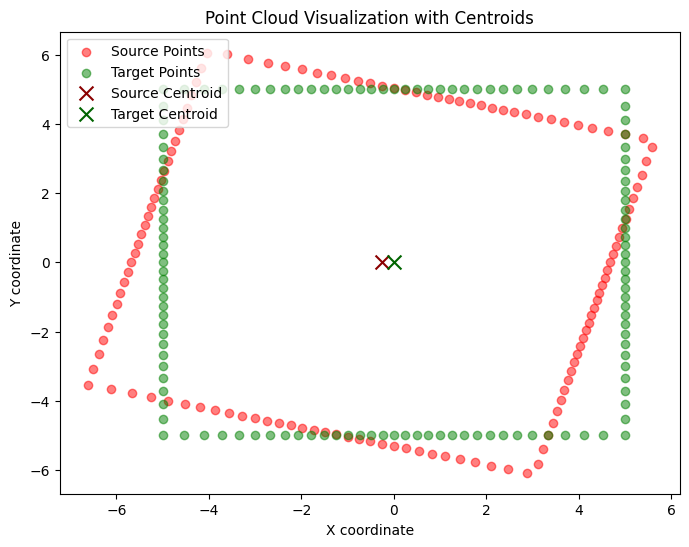

In [1]:

import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple

import tools.utils as utils 


def calculate_centroid(points: np.ndarray) -> np.ndarray:
    """
    Calculate the centroid of a set of points.

    Parameters:
        points (np.ndarray): An array of points of shape (n_points, 3).

    Returns:
        np.ndarray: The centroid of the points.
    """
    return np.mean(points, axis=0)


# Load points
P = utils.pcd_from_path("./dataset/source.pcd") # Source points
Q = utils.pcd_from_path("./dataset/target.pcd") # Target points

# Calculate centroids
centroid_P = calculate_centroid(P)
centroid_Q = calculate_centroid(Q)

# Plotting the original and transformed point cloud
plt.figure(figsize=(8, 6))
plt.scatter(P[:,0], P[:,1], color='red', alpha=0.5, label='Source Points')
plt.scatter(Q[:,0], Q[:,1], color='green', alpha=0.5, label='Target Points')
plt.scatter(centroid_P[0], centroid_P[1], color='darkred', marker='x', s=100, label='Source Centroid')
plt.scatter(centroid_Q[0], centroid_Q[1], color='darkgreen', marker='x', s=100, label='Target Centroid')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Point Cloud Visualization with Centroids')
plt.legend(loc='upper left')
plt.show()



### Rigid Transformation Recap


A rigid transformation is a mathematical operation applied to data to transition from one coordinate system to another, involving only rotation RR and translation tt. This operation is formally defined as:

$$
P' = RP+t
$$

where:

- $P$ represents the source points.
- $P'$ represents the transformed points.
- $R$ is the rotation matrix that rotates each point around the origin.
- $t$ is the translation vector that uniformly shifts all points.


**Example**

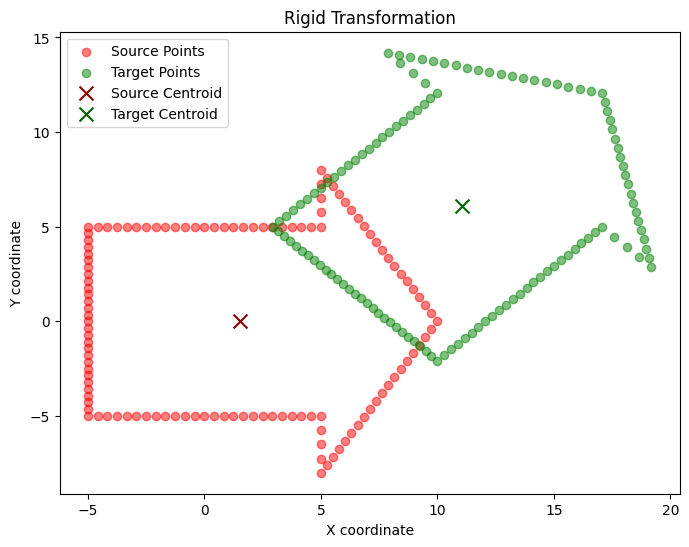

In [2]:
from scipy.spatial.transform import Rotation

def rigid_transformation(cloud: np.ndarray, R: np.ndarray, t: np.ndarray) -> np.ndarray:
    """
    Applies a rigid transformation to a point cloud.
    
    Parameters:
        cloud (np.ndarray): A point cloud array of shape (n_points, 3).
        R (np.ndarray): Rotation matrix of shape (3, 3).
        t (np.ndarray): Translation vector of shape (3, 1).
    
    Returns:
        np.ndarray: Transformed point cloud of shape (n_points, 3).
    """
    # Validate input types
    if not isinstance(cloud, np.ndarray):
        raise TypeError("The point cloud must be a numpy array.")
    if not isinstance(R, np.ndarray):
        raise TypeError("The rotation matrix must be a numpy array.")
    if not isinstance(t, np.ndarray):
        raise TypeError("The translation vector must be a numpy array.")

    # Validate input dimensions
    if cloud.ndim != 2 or cloud.shape[1] != 3:
        raise ValueError("Point cloud shape must be (n_points, 3).")
    if R.shape != (3, 3):
        raise ValueError("Rotation matrix must have shape (3, 3).")
    if t.shape != (3, 1):
        raise ValueError("Translation vector must have shape (3, 1).")

    # Validate matrix compatibility
    if cloud.shape[1] != R.shape[0]:
        raise ValueError("The number of columns in the point cloud must match the number of rows in the rotation matrix.")
    
    return (R @ cloud.T + t).T

# Create rigid transformation parameters
t = np.array([[10], [5], [0]])  # Translation vector

# Rotation matrix using Roll, Pitch, Yaw (only yaw is non-zero for 2D rotation around Z)
yaw = 45  # 45 degrees over z axis
R = Rotation.from_euler('z', yaw, degrees=True).as_matrix()

# Load points from a file
P = utils.pcd_from_path("./dataset/arrow.pcd")

# Apply transformation
Q = rigid_transformation(P, R, t)

# Calculate centroids
centroid_P = calculate_centroid(P)
centroid_Q = calculate_centroid(Q)

# Plotting the original and transformed point cloud
plt.figure(figsize=(8, 6))
plt.scatter(P[:,0], P[:,1], color='red', alpha=0.5, label='Source Points')
plt.scatter(Q[:,0], Q[:,1], color='green', alpha=0.5, label='Target Points')
plt.scatter(centroid_P[0], centroid_P[1], color='darkred', marker='x', s=100, label='Source Centroid')
plt.scatter(centroid_Q[0], centroid_Q[1], color='darkgreen', marker='x', s=100, label='Target Centroid')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Rigid Transformation')
plt.legend()
plt.show()


### Least Square Optimization

As previously discussed, the core objective of the ICP algorithm is to find the rotation matrix $R$ and translation vector $t$ that minimize the error between the transformed source points $P'$ and the target points $Q$. This objective is achieved through least squares optimization, which quantifies the error using the least squares error metric. The error is formally defined as:

$$
E =  \frac{1}{N}\sum_{i=1}^N  || q_i - p'_i ||^2
$$

Where $p'_i=Rp_i+t​$ for each point $p_i$ in the source set $P$, leading to the expression:

$$
E(R,t) = \frac{1}{N}\sum_{i=1}^N  || q_i - (Rp_i + t)||^2
$$

To solve this problem, the ICP algorithm employs an optimization strategy that seeks to minimize this error function, expressed as:

$$
\operatorname*{arg\,min}_{R,t} \frac{1}{N}\sum_{i=1}^N  || q_i - Rp_i - t||^2
$$


### Single Value Decomposition (SVD) Optimization

To address the problem of finding the optimal rotation matrix $R$ and translation vector $t$, we employ an optimization strategy based on Singular Value Decomposition (SVD). This method requires a prior understanding of the correspondences between points in sets $P$ and $Q$, specifically knowing which pairs of indices $i$ and $j$ correspond such that:

$$p_i \rightarrow q_j$$

#### Solving for t

Assuming $R$ is fixed, we first focus on optimizing $t$. For this, we set the gradient of the error function $\nabla E(t)$ to zero:

$$\nabla E(t) = \frac{\partial E}{\partial t} = 0$$

Performing the derivative, we find:

$$\nabla E(t) = \frac{1}{N}\sum_{i=1}^N  -2(q_i -Rp_i -t)$$

This equation can be simplified further:

$$\nabla E(t) = 2\left(R\sum_{i=1}^N\frac{p_i}{N} + \sum_{i=1}^N\frac{t}{N} - \sum_{i=1}^N\frac{q_i}{N}\right)$$

Which simplifies to:

$$\nabla E(t) = 2(R\mu_P+ t - \mu_Q)$$

Solving for $t$ where $\nabla E(t)=0$:

$$ t = \mu_Q - R\mu_P$$


#### Solving for R

After substituting tt back into the original error function, we refine the equation:

$$E(R) = \frac{1}{N}\sum_{i=1}^N  || q_i - (Rp_i + \mu_Q - R\mu_P)||^2$$

Reformulating the error expression:

$$E(R) = \frac{1}{N}\sum_{i=1}^N  || (q_i - \mu_Q) - R(p_i - \mu_P)||^2$$

If we focus on the terms $(q_i - \mu_Q)$ and $(p_i - \mu_P)$ these can be recognized as the coordinates of the points re-centered at the origin, denoted as $q_i^c$ and $p_i^c$ respectively: 

$$
p_i^c = (p_i - \mu_P) 
$$
$$
q_i^c = (q_i - \mu_P) 
$$

Given the re-centered coordinates $p_i^c$​ and $q_i^c$, the error function can be effectively represented as the alignment error between these centered point sets. This allows us to rewrite the error function as follows:

$$E(R) = \frac{1}{N}\sum_{i=1}^N  || q_i^c  - Rp_i^c||^2 =  \frac{1}{N}\sum_{i=1}^N ( q_i^{cT} q_i^c  -2q_i^{cT} Rp_i^c + p_i^{cT} p_i^c )$$

Since the terms $q_i^{cT} q_i^c $ and $p_i^{cT} p_i^c $, are constants with respect to $R$, we focus on minimizing $-2q_i^{c^T} Rp_i^c$. This lead us to reformulate the optimization problem as:

$$ 
    \operatorname*{arg\,min}_{R} E(R) = \operatorname*{arg\,min}_{R}(-\sum_{i=1}^Nq_i^{cT} Rp_i^c)
$$

To facilitate the computation, let us denote matrices $\mathbf{X}$ and $\mathbf{Y}$ that consist of all centered points $p_i^c$, $q_i^c$ respectively: 

$$\mathbf{X} = [p_0^c, \cdots, p_i^c, \cdots, p_N^c]$$
$$\mathbf{Y} = [q_0^c, \cdots, q_i^c, \cdots, q_N^c]$$


Considering the matrix product $\mathbf{A}=\mathbf{Y}^T\mathbf{R}\mathbf{X}$, we find:

$$
A = \begin{bmatrix}
        q_0^cRp_0^c & \cdots & q_0^cRp_i^c & \cdots & q_0^cRp_N^c \\
        \vdots & \ddots & \vdots & & \vdots \\
        q_i^c & \cdots & q_i^cRp_i^c & \cdots & q_0^cRp_N^c \\
        \vdots& & \vdots& \ddots & \vdots\\
        q_N^c & \cdots & q_N^cRp_i^c & \cdots & q_N^cRp_N^c 
    \end{bmatrix} 
$$

Therefore sum $\sum_{i=1}^Nq_i^{cT} Rp_i^c$ is the trace of matrix $\mathbf{A}$. The trace of a matrix, $\text{Tr}⁡(\mathbf{A})$, being the sum of diagonal elements of a matrix, simplifies the expresion of this sum. This reduction is particularly useful because maximizing the trace $\text{Tr}⁡(\mathbf{A})$ is equivalent to minimizing $-\sum_{i=1}^Nq_i^{cT} Rp_i^c$​, which aligns with our original problem.

**Trace Example**

In [3]:
# Define two sets of 2D points (for simplicity)
X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]]).T  # Source points in columns
Y = np.array([[2, 3], [4, 5], [6, 7], [8, 9]]).T  # Target points in columns

# Define a rotation matrix using yaw angle (45 degrees) for 2D rotation
yaw = np.radians(45)  # Convert degrees to radians
R_matrix = np.array([
    [np.cos(yaw), -np.sin(yaw)],
    [np.sin(yaw),  np.cos(yaw)]
])

# Apply rotation
A = Y.T @ R_matrix @ X

# Calculate the trace of the matrix A
trace_A = np.trace(A)

# Calculate the trace manually (only works if A.shape[0] == A.shape[1])
diagonal_sum = sum(A[i, i] for i in range(A.shape[0]))

print(f"The trace of matrix A is: {trace_A}")
print(f"The sum of the diagonal of A is: {diagonal_sum}")

The trace of matrix A is: 166.87720036002523
The sum of the diagonal of A is: 166.87720036002523


One of the properties of the trace function states:

$$\text{Tr}⁡(\mathbf{AB}) = \text{Tr}⁡(\mathbf{BA}) $$

Therefore, for the matrices involved in our SVD optimization problem:

$$\text{Tr}⁡(\mathbf{Y}^T\mathbf{R}\mathbf{X}) = \text{Tr}⁡(\mathbf{R}\mathbf{X}\mathbf{Y}^T) $$

Consider $\mathbf{X}\mathbf{Y}^T$, this matrix represents the **cross covariance** matrix $\mathbf{S}$ between $Q$ and $P$. Knowing this cross-covariance we can compute its SVD decomposition:

$$
\mathrm{SVD}(\mathbf{S}) = U\Sigma V^T
$$

Then the trace can be written as:

$$
  \text{Tr}⁡(\mathbf{R}\mathbf{X}\mathbf{Y}^T) = 
  \text{Tr}⁡(\mathbf{R}U\Sigma V^T) = 
  \text{Tr}⁡(\Sigma V^T\mathbf{R}U)  
$$

Where, $\Sigma$ is a diagonal matrix, and $V^T$ and $U$ are orthogonal matrices. In the context of SVD, $V^T$ and $U$ perform rotations without altering the scale of the data, whereas the scaling effect is exclusively governed by $\Sigma$, which is a diagonal matrix containing the singular values. Consequently, the trace is maximized when $\text{Tr}⁡(\Sigma V^T\mathbf{R}U) = \text{Tr}⁡(\Sigma)$. In simpler terms, the trace attains its maximum value when the rotation matrices ($V^T$ and $U$) align the data in such a way that the scaling factors provided by $\Sigma$ are fully utilized.

$$
   V^T\mathbf{R}U = I
$$

Finally:

$$
  \mathbf{R} = VU^T
$$

In [4]:
def align_svd_known_correspondences(source_points: np.ndarray, target_points: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Aligns two sets of 3D points using the method of Singular Value Decomposition (SVD) based on known correspondences.
    
    Parameters:
    - source_points (np.ndarray): The source points as an Nx3 numpy array.
    - target_points (np.ndarray): The target points as an Nx3 numpy array.
    
    Returns:
    - Tuple[np.ndarray, np.ndarray]: A tuple containing the rotation matrix and the translation vector.
    """

    # Validate inputs
    if not (isinstance(source_points, np.ndarray) and isinstance(target_points, np.ndarray)):
        raise ValueError("Both source_points and target_points must be numpy arrays.")
    if source_points.ndim != 2 or target_points.ndim != 2:
        raise ValueError("Both source_points and target_points must be 2-dimensional.")
    if source_points.shape[1] != 3 or target_points.shape[1] != 3:
        raise ValueError("Both source_points and target_points must have three columns (3D points).")
    if source_points.shape[0] != target_points.shape[0]:
        raise ValueError("Both source_points and target_points must have the same number of rows (correspondences).")
    

    # Calculate centroids of the source and target points
    centroid_source = calculate_centroid(source_points)
    centroid_target = calculate_centroid(target_points)
    
    # Center the points around the centroid
    centered_source = source_points - centroid_source
    centered_target = target_points - centroid_target
    
    # Compute the covariance matrix from the centered coordinates
    S = centered_source.T @ centered_target
    
    # Perform Singular Value Decomposition
    U, _, V = np.linalg.svd(S)
    
    # Compute the rotation matrix, ensuring a right-handed coordinate system
    R = V.T @ U.T

    if np.linalg.det(R) < 0:
        V[2, :] *= -1
        R = V.T @ U.T
    
    # Compute the translation vector
    tr = centroid_target - R @ centroid_source
    
    return R, tr[:, np.newaxis]

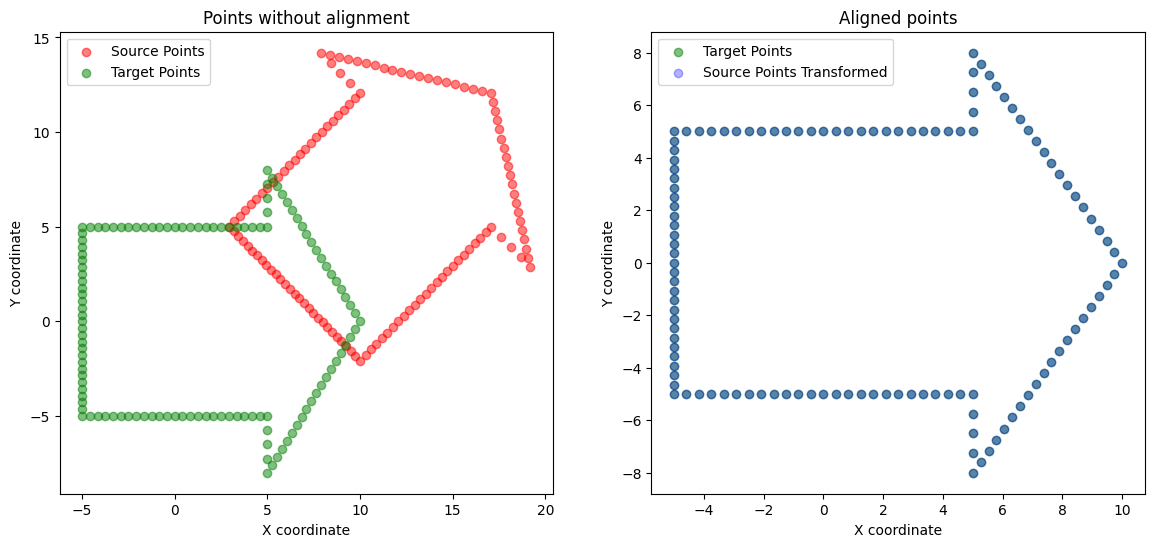

In [5]:
# Load points from a file
Q = utils.pcd_from_path("./dataset/arrow.pcd")

# Create rigid transformation parameters
t = np.array([[10], [5], [0]])  # Translation vector

# Rotation matrix using Roll, Pitch, Yaw (only yaw is non-zero for 2D rotation around Z)
yaw = 45  # 45 degrees over z axis
R = Rotation.from_euler('z', yaw, degrees=True).as_matrix()

# Apply transformation
P = rigid_transformation(Q, R, t)

# Calculate Rotation and Translation from P perspective
R_estimated, t_estimated = align_svd_known_correspondences(P, Q)

# Apply new transformation
P_transformed = rigid_transformation(P, R_estimated, t_estimated)

# Plotting the original and transformed point cloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot first initial problem
ax1.scatter(P[:,0], P[:,1], color='red', alpha=0.5, label='Source Points')
ax1.scatter(Q[:,0], Q[:,1], color='green', alpha=0.5, label='Target Points')
ax1.set_xlabel('X coordinate')
ax1.set_ylabel('Y coordinate')
ax1.set_title('Points without alignment')
ax1.legend()

# Plot points after finding transformation
ax2.scatter(Q[:,0], Q[:,1], color='green', alpha=0.5, label='Target Points')
ax2.scatter(P_transformed[:,0], P_transformed[:,1], color='blue', alpha=0.3, label='Source Points Transformed')
ax2.set_xlabel('X coordinate')
ax2.set_ylabel('Y coordinate')
ax2.set_title('Aligned points')
ax2.legend()

plt.show()

## Correspondences

### Problem

In our previous discussions, we examined the mathematical formulations for determining the transformation between reference systems of one point cloud to another using Least Square Optimization via SVD. However, these formulations assumed that we know the corresponding indices, indicating which points in $P$ match the points in $Q$. We initially assumed that the indices were identical.

When the indices are not identical, the covariance matrix $\mathbf{S}$ becomes indeterminate. This is because using $\mathbf{X}\mathbf{Y}^T$ does not accurately reflect the variance of points from the source relative to the target when the points do not align correctly.

**Example:**

Let’s see what happens if we use the previous function when we shuffle the points in the point set $P$.

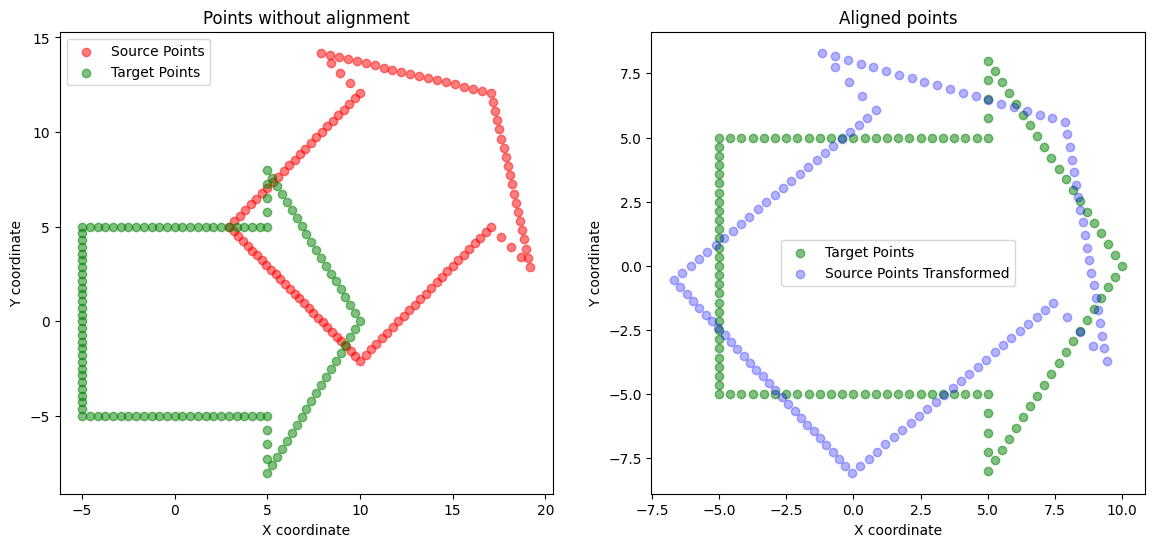

In [6]:
# Load points from a file
Q = utils.pcd_from_path("./dataset/arrow.pcd")

# Create rigid transformation parameters
t = np.array([[10], [5], [0]])  # Translation vector

# Rotation matrix using Roll, Pitch, Yaw (only yaw is non-zero for 2D rotation around Z)
yaw = 45  # 45 degrees over z axis
R = Rotation.from_euler('z', yaw, degrees=True).as_matrix()

# Apply transformation
P = rigid_transformation(Q, R, t)

# Shuffle points
rng = np.random.default_rng()
rng.shuffle(P, axis=0)

# Calculate Rotation and Translation from P perspective
R_estimated, t_estimated = align_svd_known_correspondences(P, Q)

# Apply new transformation
P_transformed = rigid_transformation(P, R_estimated, t_estimated)

# Plotting the original and transformed point cloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot first initial problem
ax1.scatter(P[:,0], P[:,1], color='red', alpha=0.5, label='Source Points')
ax1.scatter(Q[:,0], Q[:,1], color='green', alpha=0.5, label='Target Points')
ax1.set_xlabel('X coordinate')
ax1.set_ylabel('Y coordinate')
ax1.set_title('Points without alignment')
ax1.legend()

# Plot points after finding transformation
ax2.scatter(Q[:,0], Q[:,1], color='green', alpha=0.5, label='Target Points')
ax2.scatter(P_transformed[:,0], P_transformed[:,1], color='blue', alpha=0.3, label='Source Points Transformed')
ax2.set_xlabel('X coordinate')
ax2.set_ylabel('Y coordinate')
ax2.set_title('Aligned points')
ax2.legend()

plt.show()

As you can observe, the points do not align correctly because the rotation is incorrect. You can execute the previous cell multiple times to see how the algorithm fails to converge to a specific solution.

### Solution: Neighrest Neighbor

Since it's necessary to determine correspondences between the indices of $P$ and $Q$, where:

$$ (i,j) : q_j = \mathbf{R}p_i+t$$

We can use a nearest neighbor approach to find the pairs $(i,j)$. Point $p_i$​ from the source points $P$ corresponds to point $q_j$​ from the target points $Q$. However, computing all distances directly between every point in $P$ and $Q$ is computationally intensive. Thus, to efficiently solve this problem, we can utilize a **K-Dimensional Tree (KD-Tree)**.

A KD-Tree is a binary search tree that organizes multi-dimensional data hierarchically, enabling quick nearest-neighbor searches. Each node splits the space along an axis, alternating between dimensions at each level. This hierarchical organization allows the KD-Tree to prune irrelevant branches, speeding up nearest neighbor queries.

**Example of Using a KD-Tree for Correspondence:**

1. **Build the KD-Tree:** Organize the **centered** target point clouds into a KD-Tree.
2. **Query for Correspondences:** For each **centered** source point in $P$, search the KD-Tree to find the nearest neighbor within a specified radius.
3. **Handle No Match:** If no neighbor is found within the maximum radius, the source point is considered unassociated.

Let's examine how to establish these correspondences for a set of source points $P$ and target points $Q$ in Python.

In [7]:
from scipy.spatial import KDTree

def get_correspondences(source_points:np.ndarray, target_points: np.ndarray, max_dist : float =10):
    # Validate inputs
    if not (isinstance(source_points, np.ndarray) and isinstance(target_points, np.ndarray)):
        raise ValueError("Both source_points and target_points must be numpy arrays.")
    if source_points.ndim != 2 or target_points.ndim != 2:
        raise ValueError("Both source_points and target_points must be 2-dimensional.")
    if source_points.shape[1] != 3 or target_points.shape[1] != 3:
        raise ValueError("Both source_points and target_points must have three columns (3D points).")
    if source_points.shape[0] != target_points.shape[0]:
        raise ValueError("Both source_points and target_points must have the same number of rows (correspondences).")
    
    centroid_source = calculate_centroid(source_points)
    centroid_traget = calculate_centroid(target_points)

    centered_source = source_points - centroid_source
    centered_target = target_points - centroid_traget
    
    # build KDTree
    tree = KDTree(centered_target)

    # Find nearest neighbors
    distances, indices = tree.query(centered_source)
    
    # Compute correspondences
    correspondences = np.asarray([(i, j) for i, j in enumerate(indices)])
    
    # Filter correspondences
    mask = distances < max_dist
    correspondences = correspondences[mask, :]
    
    return correspondences

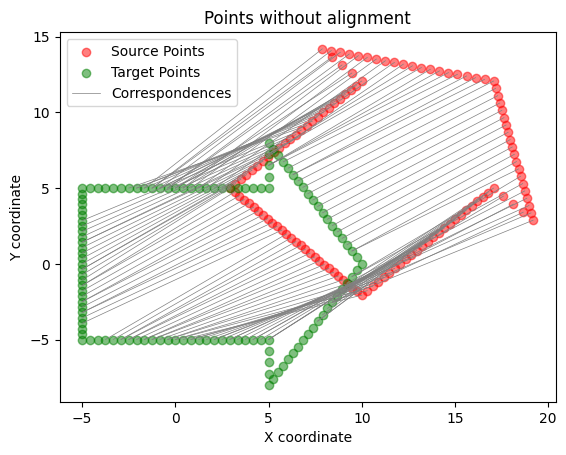

In [8]:
# Load points from a file
Q = utils.pcd_from_path("./dataset/arrow.pcd")

# Create rigid transformation parameters
t = np.array([[10], [5], [0]])  # Translation vector

# Rotation matrix using Roll, Pitch, Yaw (only yaw is non-zero for 2D rotation around Z)
yaw = 45  # 45 degrees over z axis
R = Rotation.from_euler('z', yaw, degrees=True).as_matrix()

# Apply transformation
P = rigid_transformation(Q, R, t)

# Shuffle points
rng = np.random.default_rng()
rng.shuffle(P, axis=0)

correspondences = get_correspondences(P, Q)


# Plotting the original and transformed point cloud
plt.figure()

# Plot first initial problem
plt.scatter(P[:,0], P[:,1], color='red', alpha=0.5, label='Source Points')
plt.scatter(Q[:,0], Q[:,1], color='green', alpha=0.5, label='Target Points')

# Plot correspondences
label = "Correspondences"
for i,j in correspondences:
    plt.plot([P[i,0], Q[j,0]], [P[i,1], Q[j,1]], 'grey', lw=0.5, label=label)
    label = ''

# Plot params
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Points without alignment')
plt.legend()

plt.show()

Let's see what happens when we use this algorithm to align two point clouds, taking advantage of SVD with nearest-neighbor correspondences identified via KD-Tree.

In [9]:
def align_svd_one_iteration(source_points: np.ndarray, target_points: np.ndarray, max_dist: float = 10) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Aligns two sets of 3D points using the method of Singular Value Decomposition (SVD) based on known correspondences.
    
    Parameters:
    - source_points (np.ndarray): The source points as an Nx3 numpy array.
    - target_points (np.ndarray): The target points as an Nx3 numpy array.
    
    Returns:
    - Tuple[np.ndarray, np.ndarray]: A tuple containing the rotation matrix and the translation vector.
    """

    # Validate inputs
    if not (isinstance(source_points, np.ndarray) and isinstance(target_points, np.ndarray)):
        raise ValueError("Both source_points and target_points must be numpy arrays.")
    if source_points.ndim != 2 or target_points.ndim != 2:
        raise ValueError("Both source_points and target_points must be 2-dimensional.")
    if source_points.shape[1] != 3 or target_points.shape[1] != 3:
        raise ValueError("Both source_points and target_points must have three columns (3D points).")
    if source_points.shape[0] != target_points.shape[0]:
        raise ValueError("Both source_points and target_points must have the same number of rows (correspondences).")
    

    # Calculate centroids of the source and target points
    centroid_source = calculate_centroid(source_points)
    centroid_target = calculate_centroid(target_points)
    
    # Center the points around the centroid
    centered_source = source_points - centroid_source
    centered_target = target_points - centroid_target
    
    # Build KDTree
    tree = KDTree(centered_target)

    # Find nearest neighbors
    distances, indices = tree.query(centered_source)
    
    # Compute correspondences
    correspondences = np.asarray([(i, j) for i, j in enumerate(indices)])
    
    # Filter correspondences
    mask = distances < max_dist
    correspondences = correspondences[mask, :]

    # Sort acording to correspondences
    sorted_source = centered_source[correspondences[:, 0]]
    sorted_target = centered_target[correspondences[:, 1]]

    # Compute the covariance matrix from the centered coordinates
    S = sorted_source.T @ sorted_target
    
    # Perform Singular Value Decomposition
    U, _, V = np.linalg.svd(S)
    
    # Compute the rotation matrix, ensuring a right-handed coordinate system
    R = V.T @ U.T

    if np.linalg.det(R) < 0:
        V[2, :] *= -1
        R = V.T @ U.T
    
    # Compute the translation vector
    tr = centroid_target - R @ centroid_source
    
    return R, tr[:, np.newaxis], correspondences

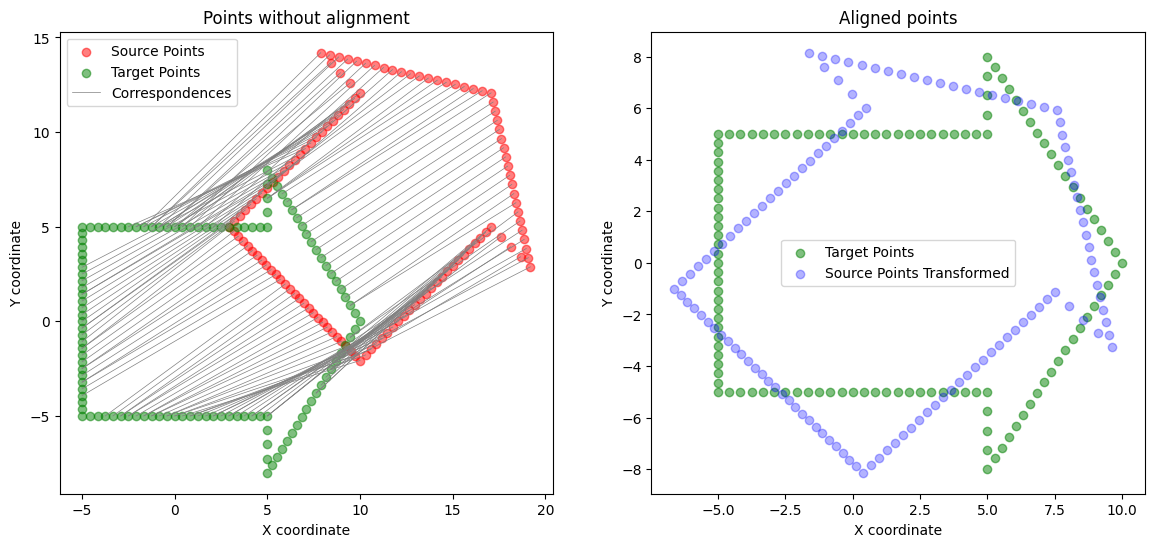

In [10]:
# Load points from a file
Q = utils.pcd_from_path("./dataset/arrow.pcd")

# Create rigid transformation parameters
t = np.array([[10], [5], [0]])  # Translation vector

# Rotation matrix using Roll, Pitch, Yaw (only yaw is non-zero for 2D rotation around Z)
yaw = 45  # 45 degrees over z axis
R = Rotation.from_euler('z', yaw, degrees=True).as_matrix()

# Apply transformation
P = rigid_transformation(Q, R, t)

# Shuffle points
rng = np.random.default_rng()
rng.shuffle(P, axis=0)

# Calculate Rotation and Translation from P perspective
R_estimated, t_estimated, correspondences = align_svd_one_iteration(P, Q)

# Apply new transformation
P_transformed = rigid_transformation(P, R_estimated, t_estimated)

# Plotting the original and transformed point cloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot first initial problem
ax1.scatter(P[:,0], P[:,1], color='red', alpha=0.5, label='Source Points')
ax1.scatter(Q[:,0], Q[:,1], color='green', alpha=0.5, label='Target Points')

# Plot correspondences
label = "Correspondences"
for i,j in correspondences:
    ax1.plot([P[i,0], Q[j,0]], [P[i,1], Q[j,1]], 'grey', lw=0.5, label=label)
    label = ''

ax1.set_xlabel('X coordinate')
ax1.set_ylabel('Y coordinate')
ax1.set_title('Points without alignment')
ax1.legend()

# Plot points after finding transformation
ax2.scatter(Q[:,0], Q[:,1], color='green', alpha=0.5, label='Target Points')
ax2.scatter(P_transformed[:,0], P_transformed[:,1], color='blue', alpha=0.3, label='Source Points Transformed')
ax2.set_xlabel('X coordinate')
ax2.set_ylabel('Y coordinate')
ax2.set_title('Aligned points')
ax2.legend()

plt.show()

The algorithm demonstrates stability regardless of point ordering, consistently reaching a local solution. However, it fails to achieve a global solution due to two primary issues:

1. **Multiple Source Points Matching a Single Target Point:** Several source points mapping to the same target point can lead to distortions from ambiguous associations, where nearest neighbor searches assign multiple source points to a single target point without discrimination.

2. **Unmatched Source Points:** Some source points do not find corresponding targets, likely due to occlusion, noise, or regions where the point clouds do not overlap. These unmatched points can disrupt the overall alignment accuracy.

Despite these initial challenges, the alignment process can serve as the foundational step in a more comprehensive approach to solving the global alignment problem. This initial solution, often considered the first iteration in the Iterative Closest Point algorithm, sets the stage for further refinement

## Iteratice Closest Point Algorithm

The Iterative Closest Point (ICP) algorithm is an iterative process that aims to refine the initial alignment to reach a globally optimal solution. In each iteration, the previously computed transformation is used to transform the source point cloud, reducing the distance between the source and target points. This process is repeated until the rotation matrix ($R_n$) and translation vector ($t_n$) at iteration  $n$ converge to identity and zero, respectively, or until a maximum number of iterations is reached.


### Algorithm Steps

1. **Initial Alignment:** The source and target point clouds are pre-aligned based on an initial guess or a rough estimation. This can be derived from prior knowledge or a previous state in a sequence.

2. **Nearest Neighbor Search:** For each point in the source point cloud, find the closest point in the target point cloud. This step is crucial and can significantly affect the performance and outcome of the algorithm.

3. **Correspondence Matching:** Pair each point from the source with its closest point found in the target. These pairs are considered as correspondences.

4. **Transformation Estimation:** Compute the optimal rigid transformation (rotation and translation) that minimizes the distances between matched pairs. This is typically done using Singular Value Decomposition (SVD) or a similar method to solve the least squares problem.

5. **Transformation:** Apply the computed transformation to the source points, bringing them closer to the target points.

6. Accumulate Transformation: Update the accumulated transformation:
    $$\mathbf{R} \rightarrow \mathbf{R} \times \mathbf{R}_n $$
    $$t \rightarrow \mathbf{R_n} t +  t_n $$

7. **Iteration:** Repeat steps 2 through 5 until convergence criteria are met. Convergence can be determined by a small change in the error metric or a fixed number of iterations.

8. **Final Alignment:** Once converged, the source points should be optimally aligned to the target points under the computed transformation

### Implementation

Below is a Python implementation of the ICP using SVD for transformation estimation and a KD-Tree for efficient nearest neighbor searches. This example shows how to apply the ICP algorithm to align 2D point clouds iteratively:

#### Function

In [12]:
def align_svd(source_points: np.ndarray, target_points: np.ndarray, max_dist: float = 100, max_iter: int=100, tol=1e-5) -> np.ndarray:
    
    # Calculate centroids of the source and target points
    centroid_target = calculate_centroid(target_points)

    # Center the points around the centroid
    centered_target = target_points - centroid_target
    
    # Build KDTree
    tree = KDTree(centered_target)

    # Initilialize R and t
    R = np.eye(target_points.shape[1])
    t = np.zeros((target_points.shape[1], 1))

    R_list = [R]
    t_list = [t]
    corres_values_list = []

    for iteration in range(max_iter):
        # Center source
        centroid_source = calculate_centroid(source_points)
        centered_source = source_points - centroid_source

        # Find nearest neighbors
        distances, indices = tree.query(centered_source)
        # Compute correspondences
        correspondences = np.asarray([(i, j) for i, j in enumerate(indices)])

        mask = distances < max_dist
        
        # Filter correspondences
        correspondences = correspondences[mask, :]
        
        # Sort points
        sorted_source = centered_source[correspondences[:, 0]]
        sorted_target = centered_target[correspondences[:, 1]]

        #  Compute covariance matrix
        S = sorted_source.T @ sorted_target
    
        # Perform Singular Value Decomposition
        U, _, V = np.linalg.svd(S)
        
        # Compute the rotation matrix, ensuring a right-handed coordinate system
        Rn = V.T @ U.T

        # Compute the translation vector
        tn = centroid_target - Rn @ centroid_source
        tn = tn[:,np.newaxis]
        source_points = rigid_transformation(source_points, Rn, tn)
        
        # Update transformation
        t = Rn @ t + tn
        R = np.dot(R, Rn)
        
        t_list.append(t.copy())
        R_list.append(R.copy())
        corres_values_list.append(correspondences.copy())

        if np.allclose(tn, 0, atol=tol) and np.allclose(Rn, np.eye(Rn.shape[0]), atol=tol):
            break

    return R, t, R_list, t_list, corres_values_list

#### Usage Example 1

In [13]:
# Load points from a file
Q = utils.pcd_from_path("./dataset/arrow.pcd")

# Create rigid transformation parameters
t = np.array([[10], [5], [0]])  # Translation vector

# Rotation matrix using Roll, Pitch, Yaw (only yaw is non-zero for 2D rotation around Z)
yaw = 45  # 45 degrees over z axis
R = Rotation.from_euler('z', yaw, degrees=True).as_matrix()

# Apply transformation
P = rigid_transformation(Q, R, t)

# Shuffle points
rng = np.random.default_rng()
rng.shuffle(P, axis=0)

# Calculate Rotation and Translation from P perspective
R_estimated, t_estimated, R_list, t_list, corres_list = align_svd(P, Q, max_dist=1)

# Animate result
utils.animate_icp_results(P,Q, R_list, t_list, corres_list)

In [14]:
# Load points from a file
P = utils.pcd_from_path("./dataset/source.pcd")
Q = utils.pcd_from_path("./dataset/target.pcd")

# Calculate Rotation and Translation from P perspective
R_estimated, t_estimated, R_list, t_list, corres_list = align_svd(P, Q, max_dist=1)

# Animate result
utils.animate_icp_results(P,Q, R_list, t_list, corres_list)

## ICP Class

We have provided you with an ICP class that you can use for aligning pointclouds

In [15]:
from tools.ICP import ICP

# Load points from a file
Q = utils.pcd_from_path("./dataset/arrow.pcd")

# Create rigid transformation parameters
t = np.array([[10], [5], [0]])  # Translation vector

# Rotation matrix using Roll, Pitch, Yaw (only yaw is non-zero for 2D rotation around Z)
yaw = 45  # 45 degrees over z axis
R = Rotation.from_euler('z', yaw, degrees=True).as_matrix()

# Apply transformation
P = rigid_transformation(Q, R, t)

# Shuffle points
rng = np.random.default_rng()
rng.shuffle(P, axis=0)

# Create ICP object
icp = ICP(max_dist=100)

# Apply aligment
R_estimated, t_estimated, R_list, t_list, corres_list = icp.align(P,Q)

# Animate result
utils.animate_icp_results(P,Q, R_list, t_list, corres_list)

In [16]:
# Load points from a file
P = utils.pcd_from_path("./dataset/source.pcd")
Q = utils.pcd_from_path("./dataset/target.pcd")

# Apply aligment
R_estimated, t_estimated, R_list, t_list, corres_list = icp.align(P,Q)

# Animate result
utils.animate_icp_results(P,Q, R_list, t_list, corres_list)